Student name: Connor Pate
Student pace: part time
Blog post URL: https://medium.com/@clpate2

Scheduled project review date/time: 11/19/20 @ 1:15

Instructor name: Amber Yandow 




## The Problem with Mental Health in U.S. Policing

#### Analyzing Mental Health and Demographics using The Washington Post's Police Shooting database

### 1. Importing Necessary Libraries 

In [1467]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
#import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import seaborn as sns
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC

from ClfAutoEDA import *
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import svm
from scipy.stats import chisquare
import sys
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor  
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.svm import SVC



### 2. Importing Datasets, Merging, and Inspecting Data

###### Washington Post Dataset Tracking Police Shootings from 2015 to Present

In [1468]:
df = pd.read_csv('fatal-police-shootings-data.csv')

In [1469]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


###### Importing State Classification Dataset to Minimize Classification Variables 

In [1470]:
states = pd.read_csv('us census bureau regions and divisions.csv')
states.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [1471]:
#Dropping the 'State' column as the primary DF uses state codes 
states = states.drop(['State'], axis=1)

In [1472]:
states = states.rename(columns={"State Code": "state"})

In [1473]:
#Merging on shared 'state' column
intact = pd.merge(states, df, on='state')
intact.head()

,state,Region,Division,id,name,date,manner_of_death,armed,age,gender,race,city,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,AK,West,Pacific,131,John Martin Whittaker,2015-02-08,shot,gun,33.0,M,W,Anchorage,False,attack,Car,False,-149.859,61.208,True
1,AK,West,Pacific,836,Tristan Vent,2015-09-08,shot,gun,19.0,M,N,Fairbanks,False,attack,Not fleeing,False,-147.779,64.827,True
2,AK,West,Pacific,816,Vincent J. Perdue,2015-09-09,shot,gun,33.0,M,N,Fairbanks,False,attack,Car,False,-147.543,64.806,True
3,AK,West,Pacific,953,Jon Ployhar,2015-10-24,shot,undetermined,49.0,M,W,Kenai Peninsula,False,attack,Not fleeing,False,-151.283,60.287,True
4,AK,West,Pacific,1166,Herman Bean,2016-01-12,shot,knife,49.0,M,N,Spenard,True,other,Not fleeing,False,-149.898,61.192,True


Dropping name and id. 

In [1474]:
data = intact.drop(['name', 'id'], axis=1)

In [1475]:
#Checking Dtype 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5740 entries, 0 to 5739
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state                    5740 non-null   object 
 1   Region                   5740 non-null   object 
 2   Division                 5740 non-null   object 
 3   date                     5740 non-null   object 
 4   manner_of_death          5740 non-null   object 
 5   armed                    5527 non-null   object 
 6   age                      5479 non-null   float64
 7   gender                   5739 non-null   object 
 8   race                     5123 non-null   object 
 9   city                     5740 non-null   object 
 10  signs_of_mental_illness  5740 non-null   bool   
 11  threat_level             5740 non-null   object 
 12  flee                     5446 non-null   object 
 13  body_camera              5740 non-null   bool   
 14  longitude               

### 3. Cleaning and Converting Data

In [1476]:
#Dropping geocoding values that are not accurate 
data = data[data.is_geocoding_exact != 'False']

In [1477]:
#Transforming Boolean values 
data = data.applymap(lambda x: 1 if x == True else x)
data = data.applymap(lambda x: 0 if x == False else x)

In [1478]:
#Checking for missing values 
data.isna().sum()

state                        0
Region                       0
Division                     0
date                         0
manner_of_death              0
armed                      213
age                        261
gender                       1
race                       617
city                         0
signs_of_mental_illness      0
threat_level                 0
flee                       294
body_camera                  0
longitude                  282
latitude                   282
is_geocoding_exact           0
dtype: int64

###### Dropping nan values and filling others 

In [1479]:
data = data.dropna(subset=['age', 'longitude', 'latitude', 'flee'])

In [1480]:
#Converting 'race' and 'armed' missing values into usable data
values = {'race': 'U', 'armed': 'undetermined'}
data = data.fillna(value=values)

In [1481]:
#Double checking missing/null values
data.isna().sum()

state                      0
Region                     0
Division                   0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
longitude                  0
latitude                   0
is_geocoding_exact         0
dtype: int64

In [1482]:
display(data.describe())

,age,signs_of_mental_illness,body_camera,longitude,latitude,is_geocoding_exact
count,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000
mean,36.988705,0.240420,0.123840,-97.038840,36.708355,0.998386
std,13.038802,0.427381,0.329432,16.622702,5.356200,0.040141
min,6.000000,0.000000,0.000000,-158.137000,19.498000,0.000000
25%,27.000000,0.000000,0.000000,-112.072000,33.490750,1.000000
50%,35.000000,0.000000,0.000000,-94.003000,36.159500,1.000000
75%,45.000000,0.000000,0.000000,-82.995500,39.993750,1.000000
max,91.000000,1.000000,1.000000,-68.014000,71.301000,1.000000


In [1483]:
#Taking a deeper look at unique values, prep for EDA
data['threat_level'].unique()
data['flee'].unique()

array(['Car', 'Not fleeing', 'Foot', 'Other'], dtype=object)

In [1484]:
#Taking a deeper look at unique values, prep for EDA
data['manner_of_death'].unique()

array(['shot', 'shot and Tasered'], dtype=object)

In [1485]:
#Examining values of the 'armed' variable 
data['armed'].value_counts()

gun                   2814
knife                  725
unarmed                334
undetermined           319
toy weapon             179
                      ... 
metal rake               1
contractor's level       1
air pistol               1
machete and gun          1
chainsaw                 1
Name: armed, Length: 92, dtype: int64

#### 3A. Examining Armed Values Prior to Conversion

In [1486]:
pie_me = data['armed'].value_counts().reset_index()
pie_me.columns = ['armed', 'count']

fig = px.pie(
    pie_me, 
    values='count', 
    names='armed',  
    title='Weapon distribution', 
    width=600, 
    height=600
)

fig.show()

#### 3B. Converting Armed Category and Inspecting New Counts

In [1487]:
#converting armed values with a count of less than 59 into 'other'
data[['armed']] = data[['armed']].where(data.apply(lambda x: x.groupby(x).transform('count')>59), 'other')

In [1488]:
data['armed'].value_counts()

gun             2814
knife            725
other            445
unarmed          334
undetermined     319
toy weapon       179
vehicle          142
Name: armed, dtype: int64

In [1489]:
pie_me = data['armed'].value_counts().reset_index()
pie_me.columns = ['armed', 'count']

fig = px.pie(
    pie_me, 
    values='count', 
    names='armed',  
    title='Weapon distribution', 
    width=600, 
    height=600
)

fig.show()

### 4. Initial Analysis and EDA 1 of 2

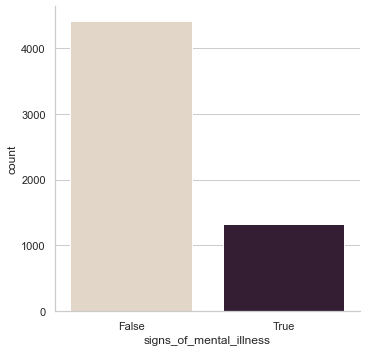

In [1490]:
sns.catplot(x="signs_of_mental_illness", kind="count", palette="ch:.25", data=intact)

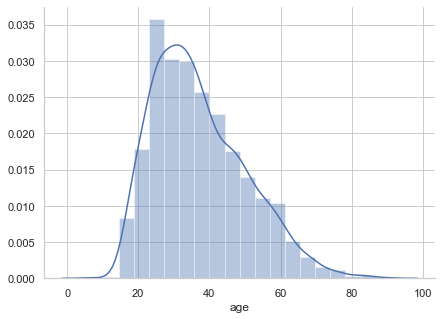

In [1491]:
#Age distribution 
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.distplot(df['age'], bins=20)

#### Inspecting different features and counts 

In [1492]:
#Checking weapon distribution
pd.crosstab(data.armed, intact.signs_of_mental_illness, normalize='index')

signs_of_mental_illness,False,True
armed,,
gun,0.790334,0.209666
knife,0.626207,0.373793
other,0.658427,0.341573
toy weapon,0.558659,0.441341
unarmed,0.811377,0.188623
undetermined,0.905956,0.094044
vehicle,0.950704,0.049296


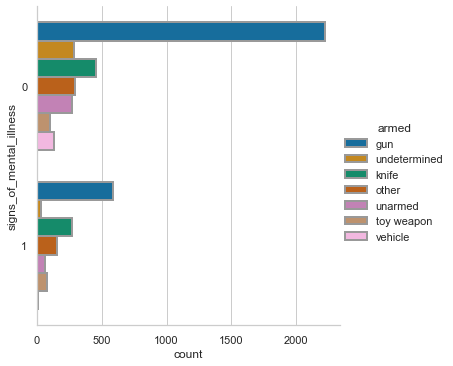

In [1493]:
#Plotting out weapon distribution
sns.catplot(y="signs_of_mental_illness", hue="armed", kind="count",
            palette="colorblind", edgecolor=".6",
            data=data, linewidth=2)

In [1494]:
#Checking race distribution 
pd.crosstab(intact.race, intact.signs_of_mental_illness, normalize='index')

signs_of_mental_illness,False,True
race,,
A,0.755319,0.244681
B,0.845414,0.154586
H,0.819810,0.180190
N,0.814815,0.185185
O,0.787234,0.212766
W,0.705000,0.295000


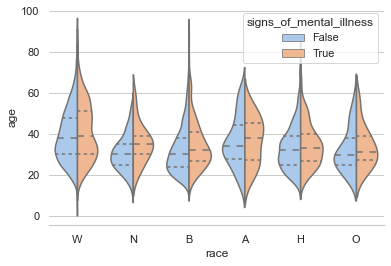

In [1495]:

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="race", y="age",  hue="signs_of_mental_illness",
               split=True, inner="quart",
               data=intact)
sns.despine(left=True)

##### Each ethnicity has its own distribution among age groups.  'W' (White, non-Hispanic) and 'A' (Asian) outpace other ethnicities by several precentage points. 'W,' in particular, makes up for almost a third of the positive mental illness stats, peaking in the 30s and remaining present until the mid 70s. 

In [1496]:
#Checking gender disparity
pd.crosstab(intact.gender, intact.signs_of_mental_illness, normalize='index')

signs_of_mental_illness,False,True
gender,,
F,0.662698,0.337302
M,0.773100,0.226900


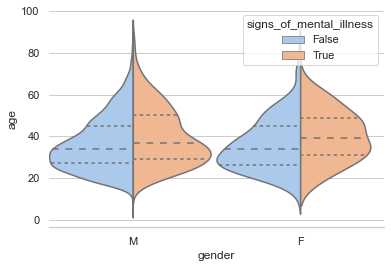

In [1497]:

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="gender", y="age",  hue="signs_of_mental_illness",
               split=True, inner="quart",
               data=intact, width=1)
sns.despine(left=True)

##### Nearly a third of women fatally shot by police display signs of mental illness. Unlike men, this trend stays consistent regardless of age. 

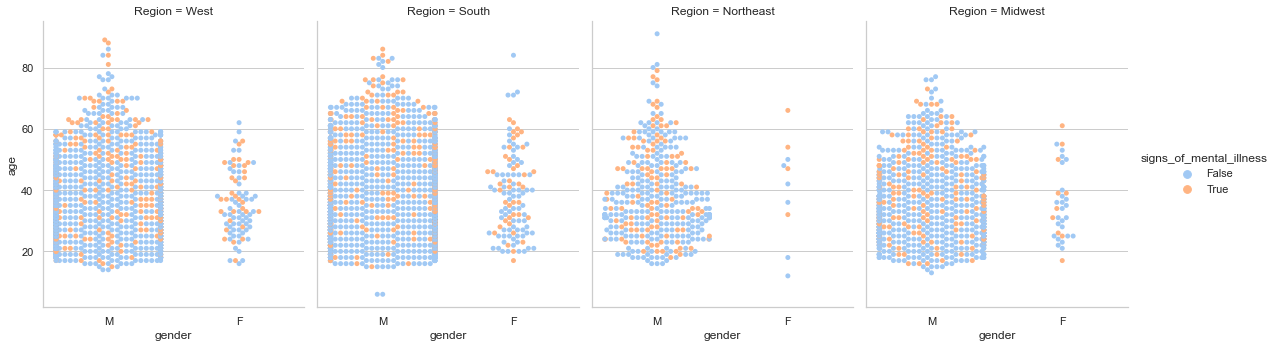

In [1498]:
#Checking gender disparity while examining region
sns.catplot(x="gender", y="age", hue="signs_of_mental_illness",
            col="Region", aspect=.8,
            kind="swarm", data=intact)

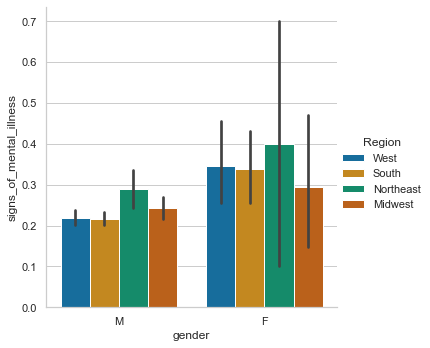

In [1499]:
#Keep Northeast in context with available information
sns.catplot(x="gender", y="signs_of_mental_illness", hue="Region", kind="bar", data=intact, palette='colorblind')

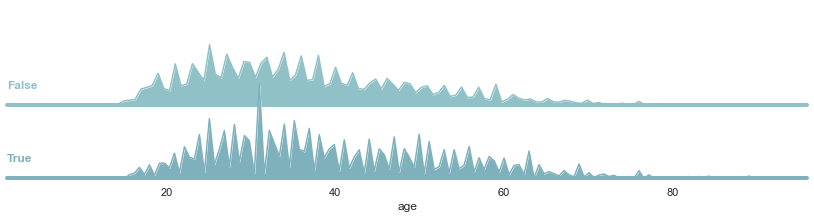

In [1500]:

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(intact, row="signs_of_mental_illness", hue="signs_of_mental_illness", 
                  aspect=7, height=1.7, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "age", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(plt.axhline, y=0, lw=4, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "age")


g.fig.subplots_adjust(hspace=-.25)


g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [1501]:
#Checking Division distribution
pd.crosstab(intact.Division, intact.signs_of_mental_illness, normalize='index')

signs_of_mental_illness,False,True
Division,,
East North Central,0.746403,0.253597
East South Central,0.805621,0.194379
Middle Atlantic,0.703448,0.296552
Mountain,0.805621,0.194379
New England,0.721154,0.278846
Pacific,0.753401,0.246599
South Atlantic,0.750000,0.250000
West North Central,0.769886,0.230114
West South Central,0.795895,0.204105


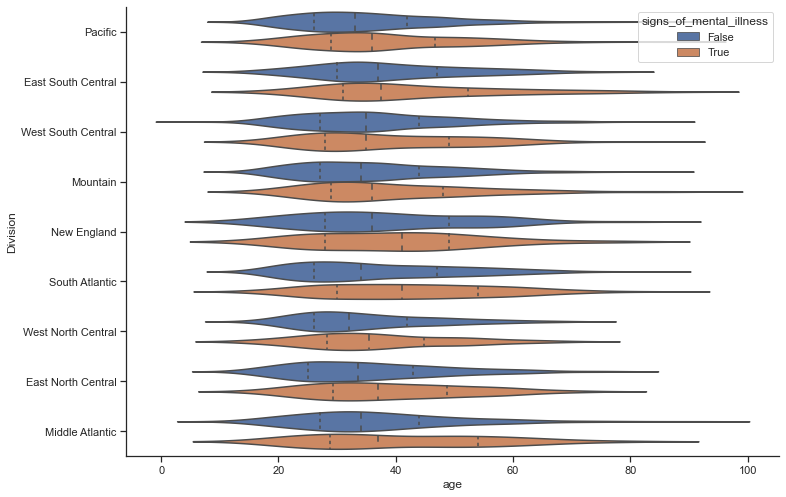

In [1502]:
# plotting Division distribution
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.violinplot(x="age", y="Division", hue="signs_of_mental_illness",
            kind="violin", data=intact, inner="quart", ax=ax)    
sns.despine()


##### Lacking uniform distribution, each age group in each Division requires independent analysis. 

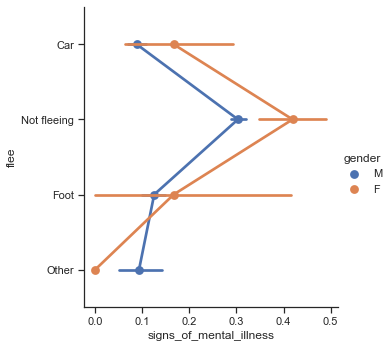

In [1503]:
sns.catplot(x="signs_of_mental_illness", y="flee", hue="gender", kind="point", data=data)

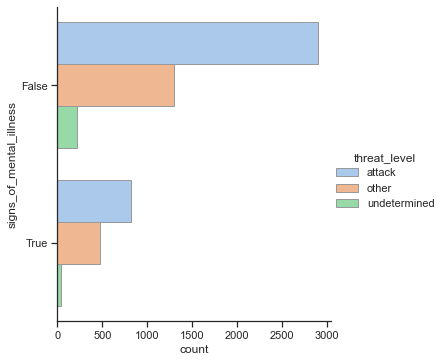

In [1504]:
sns.catplot(y="signs_of_mental_illness", hue="threat_level", kind="count",
            palette="pastel", edgecolor=".6",
            data=intact)

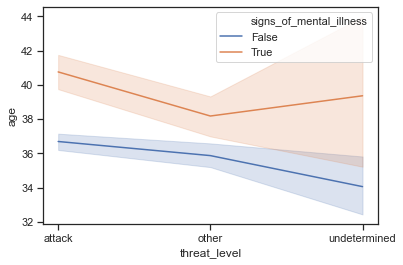

In [1505]:
sns.lineplot(x='threat_level', y='age', data=df, hue='signs_of_mental_illness')

#### 4A. Initial Analysis and EDA 2 of 2
Below is an automated EDA for the entirety of the dataset, breaking down each categorical and continuous variable. 

The data looks like this: 
   state Region Division        date manner_of_death         armed   age  \
0    AK   West  Pacific  2015-02-08            shot           gun  33.0   
1    AK   West  Pacific  2015-09-08            shot           gun  19.0   
2    AK   West  Pacific  2015-09-09            shot           gun  33.0   
3    AK   West  Pacific  2015-10-24            shot  undetermined  49.0   
4    AK   West  Pacific  2016-01-12            shot         knife  49.0   

  gender race             city  signs_of_mental_illness threat_level  \
0      M    W        Anchorage                        0       attack   
1      M    N        Fairbanks                        0       attack   
2      M    N        Fairbanks                        0       attack   
3      M    W  Kenai Peninsula                        0       attack   
4      M    N          Spenard                        1        other   

          flee  body_camera  longitude  latitude  is_geocoding_exact  
0          Car   

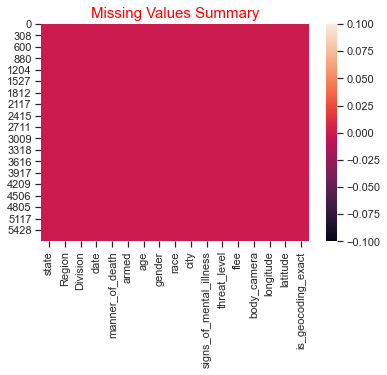

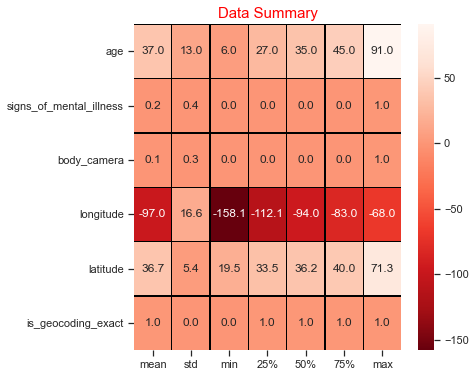

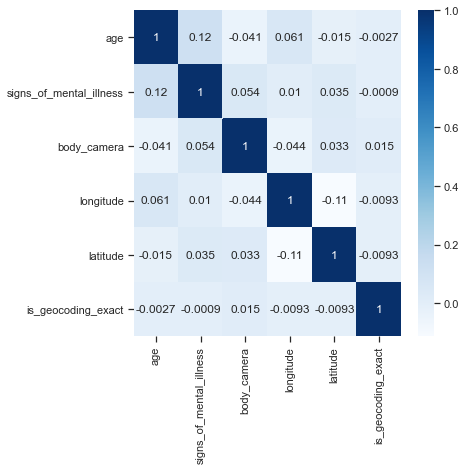

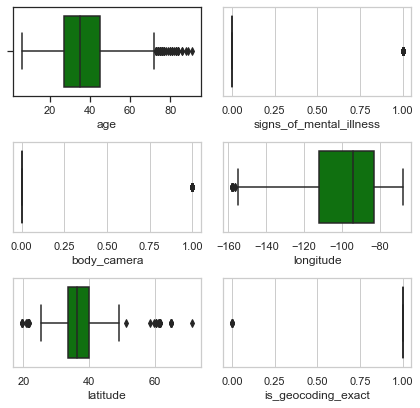

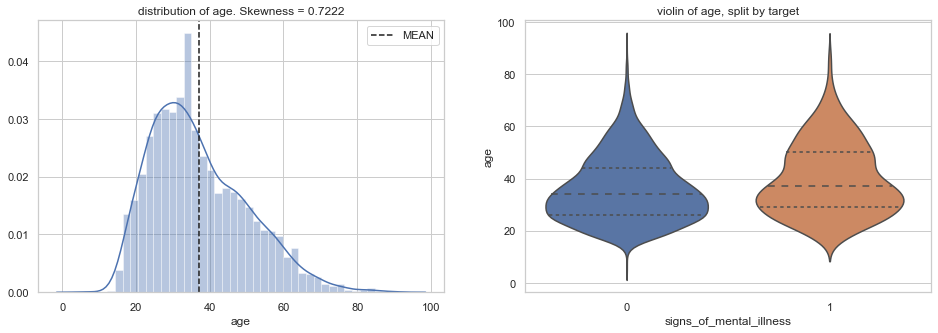

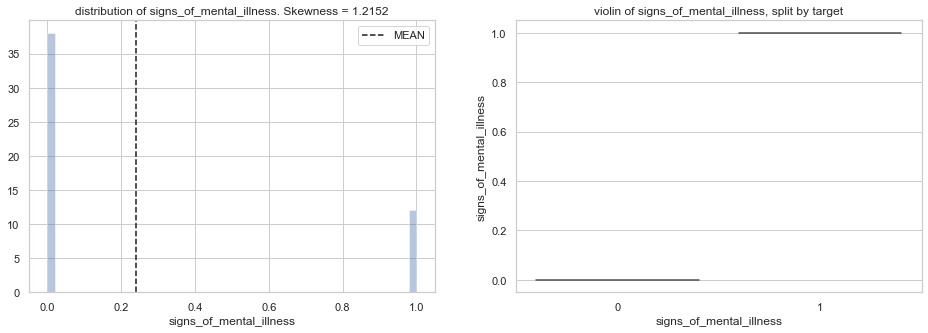

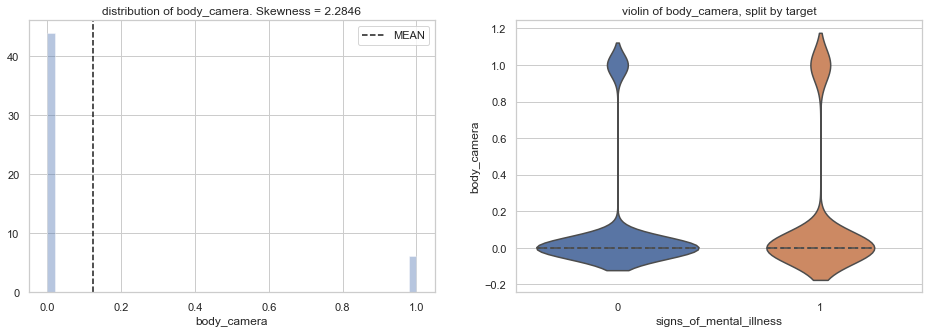

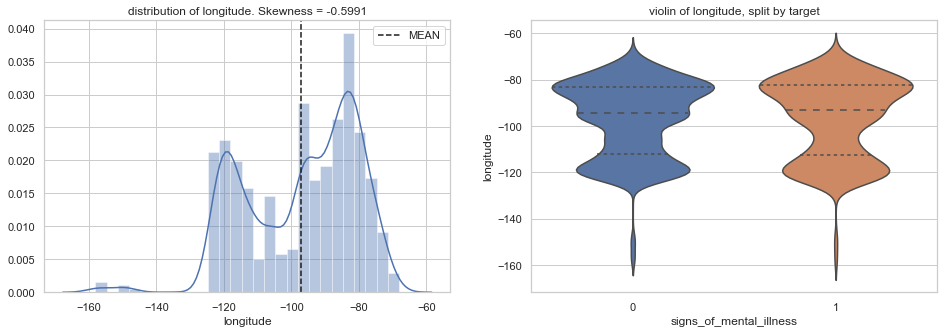

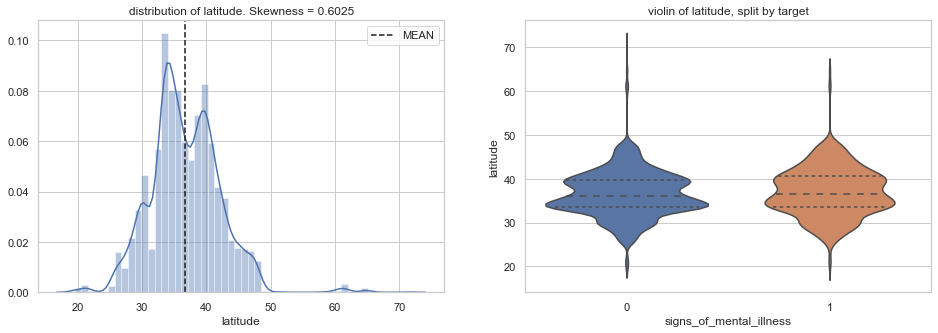

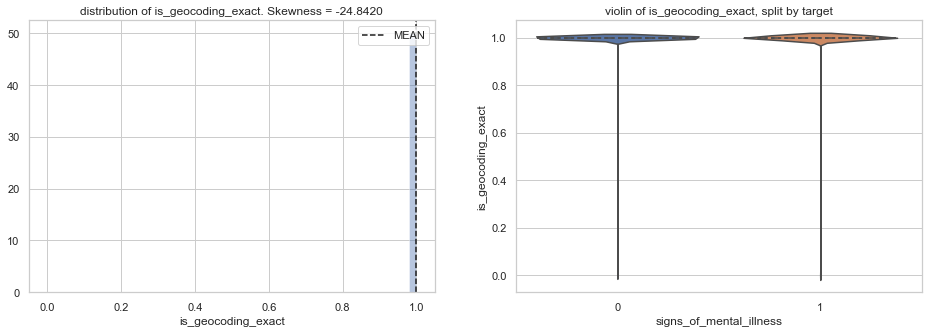

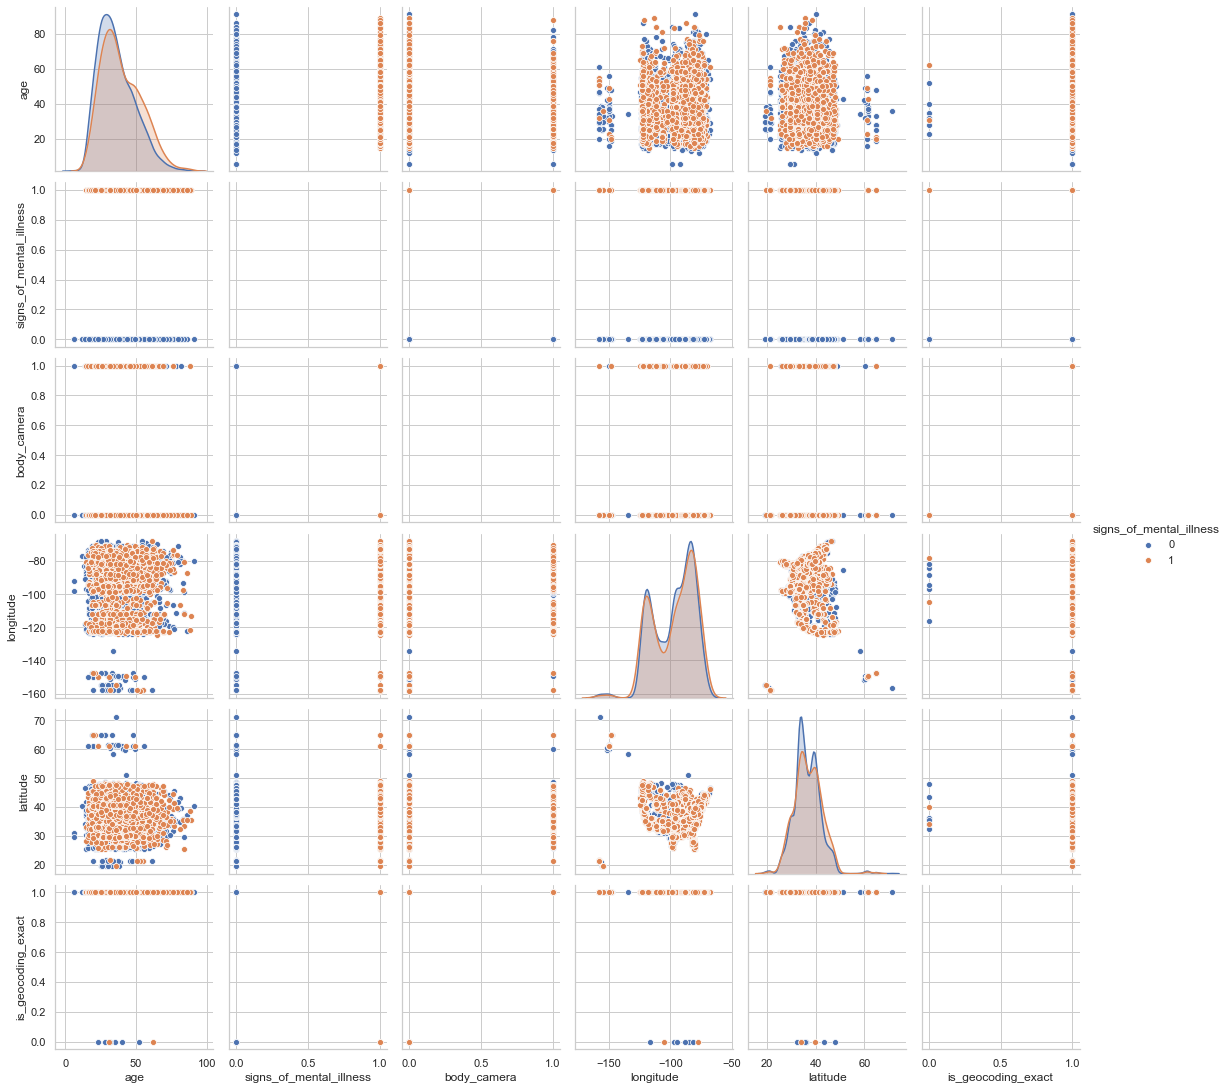

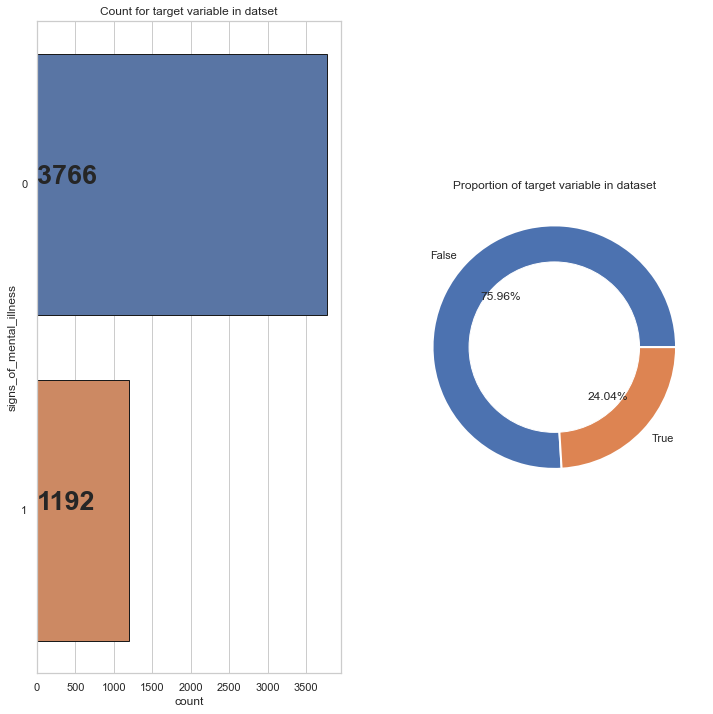

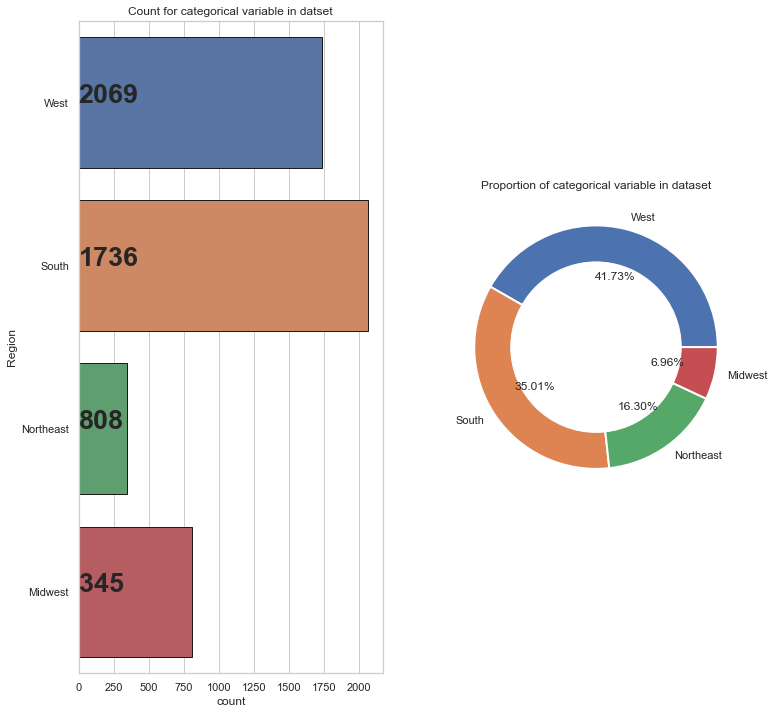

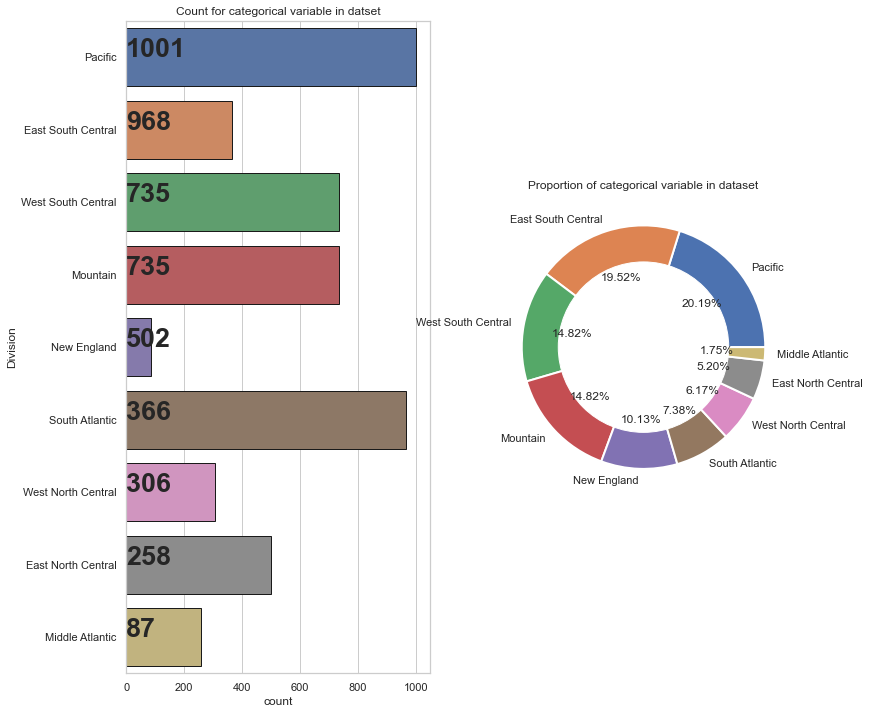

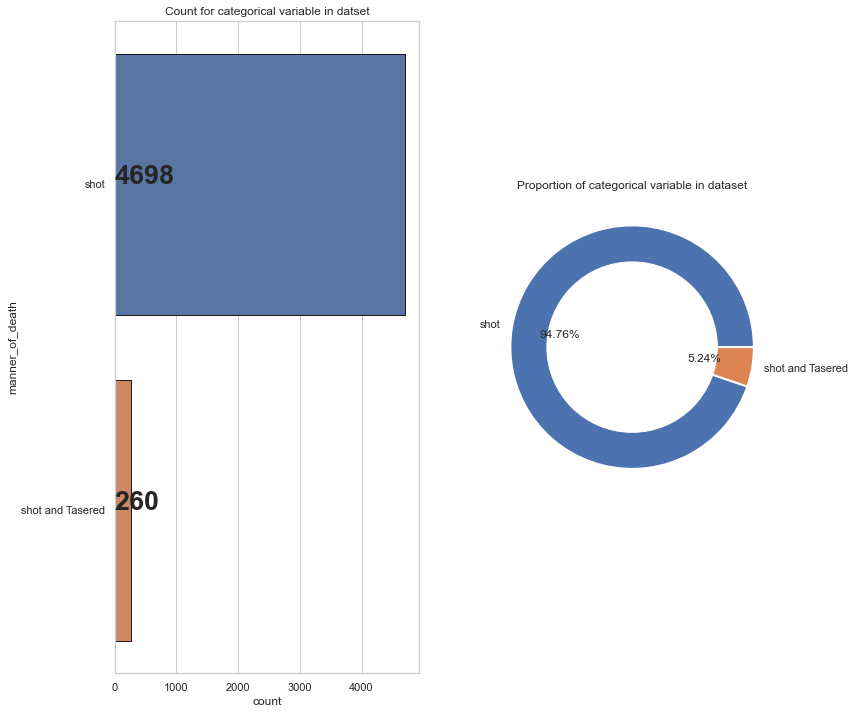

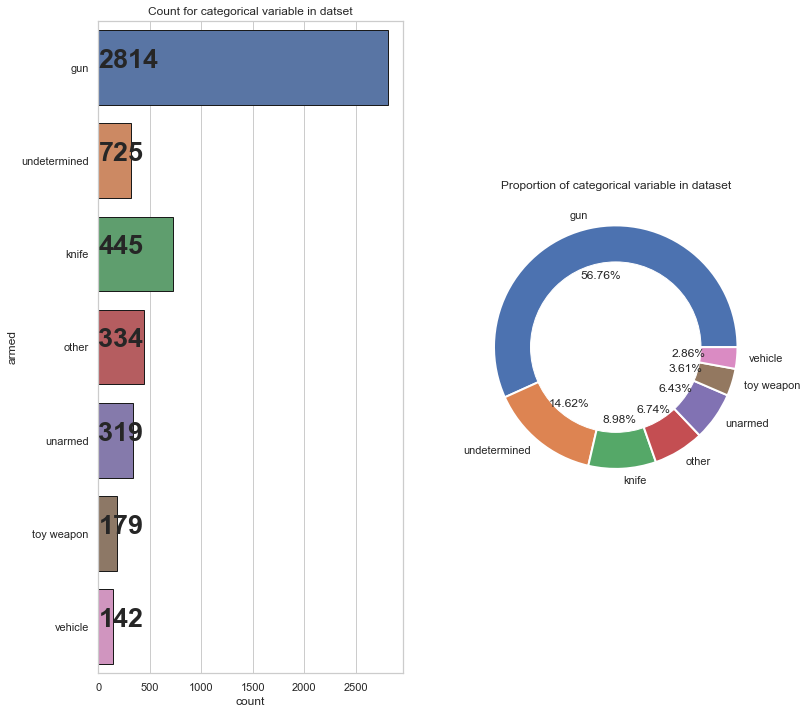

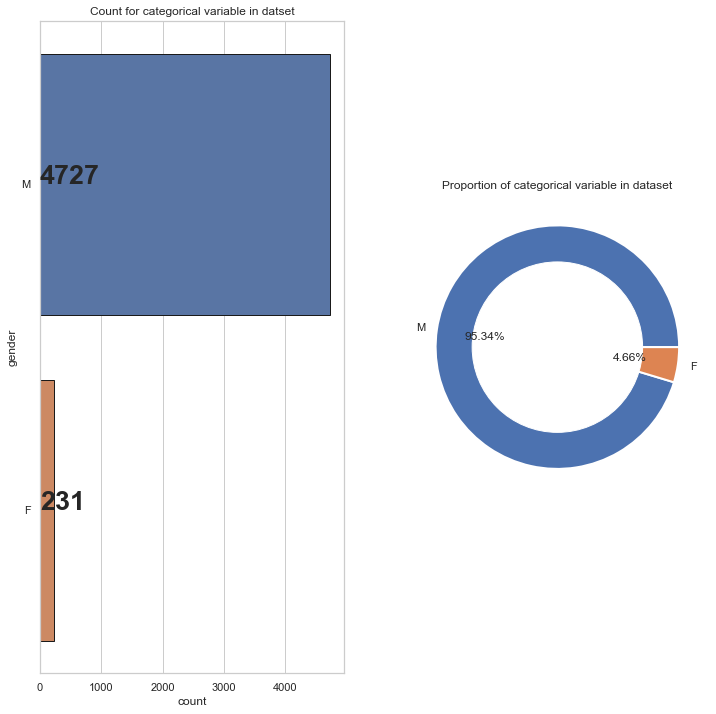

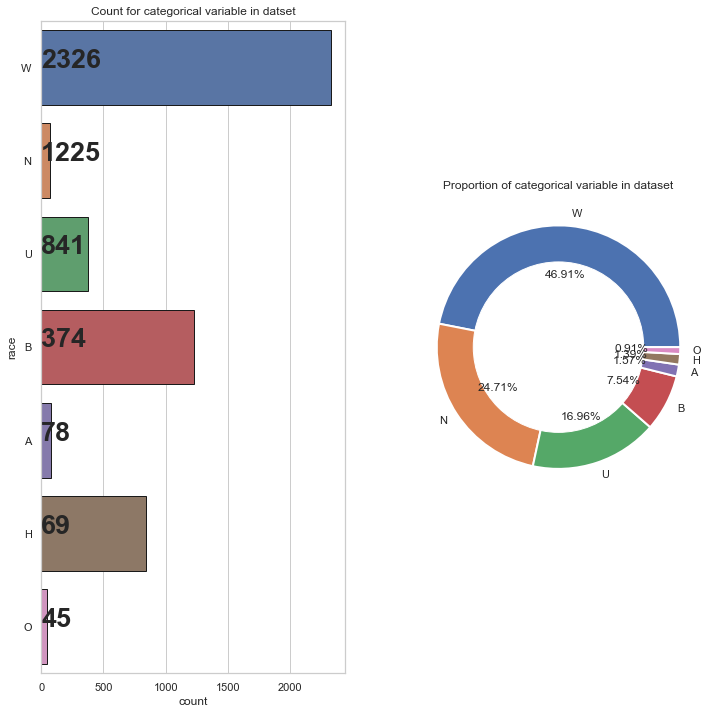

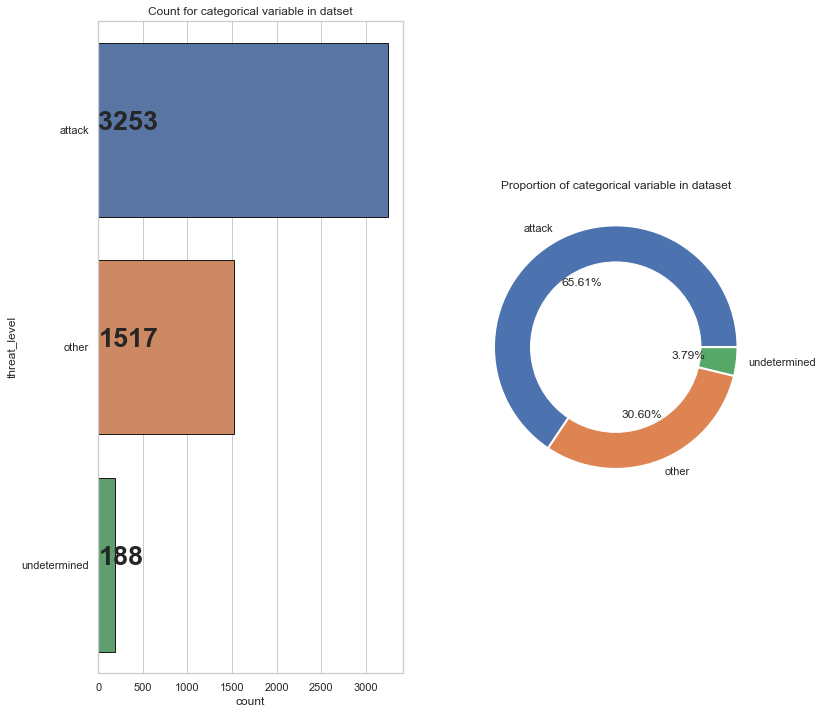

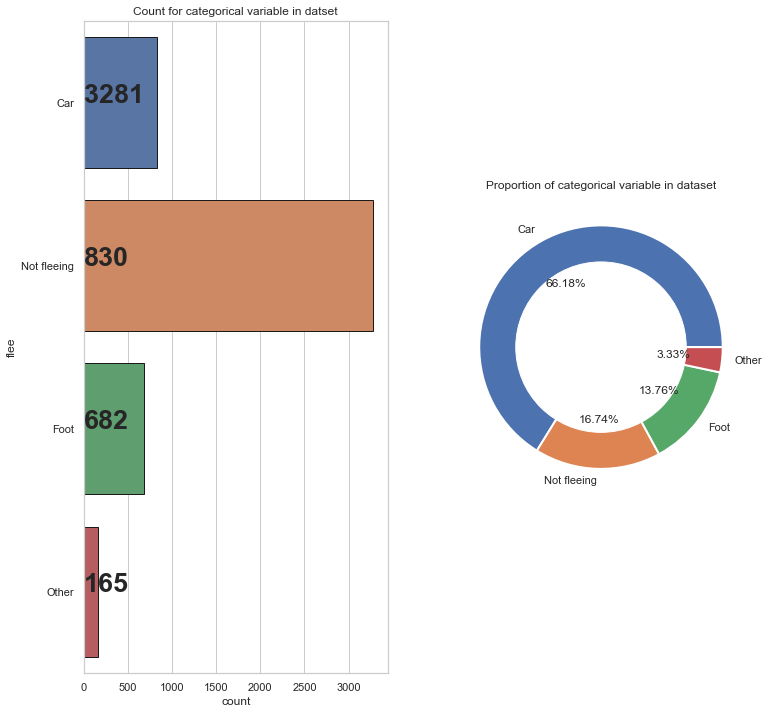

In [1506]:
#Automated EDA 
labels=["False","True"]
target_variable_name='signs_of_mental_illness'
df_processed,num_features,cat_features=EDA(data,labels,
                                         target_variable_name,
                                         data_summary_figsize=(6,6),
                                         corr_matrix_figsize=(6,6),
                                         corr_matrix_annot=True,
                                         pairplt=True)

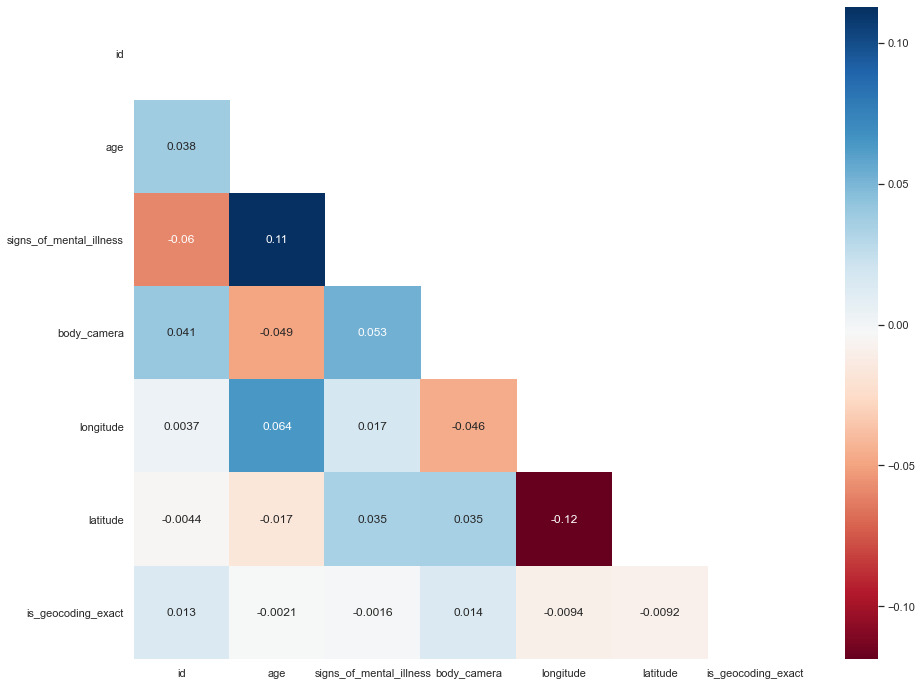

In [1507]:
plt.figure(figsize=(15,12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='RdBu', annot = True)

### 5. Final Prep Stage for Modeling: Scaling Continuous Data and Creating Dummy DF

In [1508]:
#Scaling lat, long, and age dataa 
mms = MinMaxScaler()

data[['longitude', 'latitude', 'age']] = mms.fit_transform(data[['longitude', 'latitude', 'age']])

In [1509]:
#Creating Dummy DF
dummydf = pd.get_dummies(data)
dummydf.head()

,age,signs_of_mental_illness,body_camera,longitude,latitude,is_geocoding_exact,state_AK,state_AL,state_AR,state_AZ,...,city_Yuma,city_Zanesville,city_Zion,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other
0,0.317647,0,0,0.091852,0.805166,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0.152941,0,0,0.114932,0.875027,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.317647,0,0,0.117550,0.874621,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0.505882,0,0,0.076052,0.787387,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0.505882,1,0,0.091420,0.804857,1,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


###### Creating target and feature variables

In [1510]:
#One more check of value counts before model analysis. 
data['signs_of_mental_illness'].value_counts()

0    3766
1    1192
Name: signs_of_mental_illness, dtype: int64

In [1511]:
y = dummydf['signs_of_mental_illness']
X = dummydf.drop('signs_of_mental_illness', axis=1)

### 6.  Creating Train/Test Sets and Comparing Methods of Analysis

In [1512]:
#Reshaping Y after errors in checking accuracy 
#y = y.values.reshape(4958,1)
#y.shape

In [1513]:
#Setting train/test size to 80/20 and setting random_state 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3966, 4292) (3966,)
(992, 4292) (992,)


In [1514]:
# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())

0    3019
1     947
Name: signs_of_mental_illness, dtype: int64


0    747
1    245
Name: signs_of_mental_illness, dtype: int64


In [1515]:
#Prepping for visualization of different analysis methods 
#Taking note of n_estimators, which will be assigned to deeper RF analysis 
classifier_ls = ['Logistic_Regression', 'Random_Forest', 'Decision_Tree', 'Gradient_Boosting', 'K_NN']
classifier_dc = {
               'Logistic_Regression': LogisticRegression(class_weight='auto'),
               'Random_Forest': RandomForestClassifier(n_estimators=50, class_weight='balanced'), 
               'Decision_Tree':DecisionTreeClassifier(class_weight='balanced'),
               'Gradient_Boosting': GradientBoostingClassifier(max_depth=5),
               'K_NN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
               }
n_trials = 20
test_size_rt = 0.2

In [1516]:
score_ls = []
for ic, (cl_name, Classifier) in enumerate(classifier_dc.items()):
    for trial in range(n_trials):
        train_signals, test_signals, train_labels, test_labels = train_test_split(X, y, test_size=test_size_rt, random_state=42)
        Classifier.fit(train_signals, train_labels)
        pred_labels = Classifier.predict(test_signals)
        precision = precision_score(test_labels, pred_labels, average='binary')
        score_ls.append([cl_name, precision, 'Precision'])
        recall = recall_score(test_labels, pred_labels, average='binary')
        score_ls.append([cl_name, recall,'Recall'])
        F1 = f1_score(test_labels, pred_labels, average='binary')
        score_ls.append([cl_name, F1,'f1 Score'])


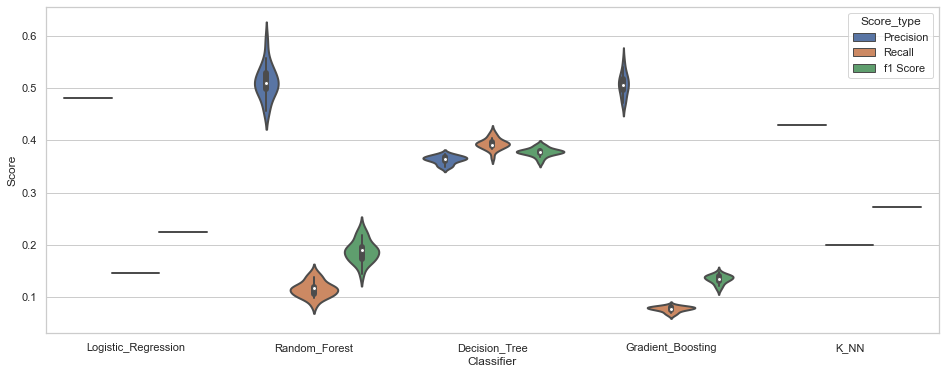

In [1517]:
# Visualizing analysis methods 
plt.figure(figsize=(16, 6))
metrics_df = pd.DataFrame(score_ls, columns=['Classifier','Score','Score_type']) 
ax = sns.violinplot(x="Classifier", y="Score", hue="Score_type", data=metrics_df, linewidth=2) 


#### These aren't great scores, but we've got some information to go on and attributes to modify to improve the models. 
1. While Gradient Boosting has a similar precision as Random Forest, its other scores are quite low. Future analysis may expand upon Gradient Boosting, but at this time, we will forgo indepth Gradient Boosting analysis
2. Random Forest's class weight and estimators will be further tuned below. Sampling may contribute to lower scores. 
3. The Decision Tree Classifier was added after further analysis of the model. While the scores look low now, we will tune the model to improve its overall performance. 
4. As demonstrated below, Logreg's performance will stay below our other chosen models. 

### 7. Logistic Regression (Model 1 of 3)
###### Steps
1. Assign LogReg
2. Check accuracy
3. ROC
4. Confusion matrix
5. Investigate scores

In [1518]:
#Increased max_iter from default (100)
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [1519]:
k_predictions = cross_val_predict(logreg, X, y, cv=10)
kfold_scores = cross_val_score(logreg, X, y, cv=10, scoring='neg_mean_squared_error')
print(kfold_scores.mean())


-0.36224014336917565


In [1520]:
print("Train Accuracy:",logreg.score(X_train, y_train))
print("Test Accuracy:",logreg.score(X_test, y_test))

Train Accuracy: 0.8756933938477055
Test Accuracy: 0.751008064516129


In [1521]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


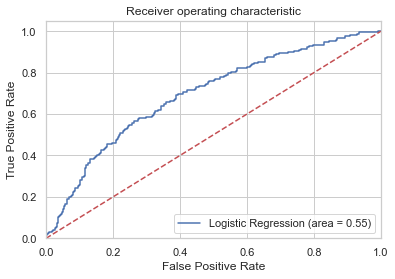

In [1522]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [1523]:
model_1 = LogisticRegression()
cross_val = KFold(n_splits=3, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Logistic Regression: ", scores.mean())

Mean AUC Score - Logistic Regression:  0.6890586874852298


Checking different parameters for Logreg - requires subset analysis 

In [1524]:
#tuned_parameters = [{'C': np.linspace(.0001, 1000, 200) , 'penalty': [ "l1", "l2"]}]
#clf = GridSearchCV(logreg, tuned_parameters, cv=cross_val, scoring= 'roc_auc')
#clf.fit(X_train, y_train)
#print("Best parameters set found on development set:")
#print()
#print(clf.best_params_)
#print("\nOptimized model achieved an ROC of:" \
      #,round(clf.score(X_train, y_train), 4))

Confusion matrix
[[708  39]
 [208  37]]


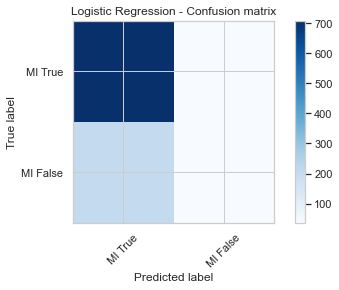

In [1525]:
def plot_confusion_matrix(cm, names, title="Logistic Regression - Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, ["MI True","MI False"])

In [1526]:
cmlg = confusion_matrix(y_test, y_pred)
print(cmlg)

[[708  39]
 [208  37]]


Result: we have 708+37 correct predictions and 208+39 incorrect predictions.

In [1527]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       747
           1       0.49      0.15      0.23       245

    accuracy                           0.75       992
   macro avg       0.63      0.55      0.54       992
weighted avg       0.70      0.75      0.70       992



#### Let's see if we can do better. 
As we will see below, while our LogReg has a similar accuracy to our DTC, it's doing a better job analyzing positive cases of mental illness (in relationship to the total dataset (recall)). 
However, our weighted averages our very similar to our DTC. 

### 8. Decision Tree Regression (Model 2 of 3)
###### Steps
1. Assign DTC
2. Check AUC and cross_val scores
3. Set parameter grid for hyperparameter tuning
4. Check accuracy and optimal parameters
5. Confusion matrix
6. Investigate scores

In [1528]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [1529]:
model2 = DecisionTreeClassifier()
cross_val = KFold(n_splits=3, random_state=42)
scores = cross_val_score(model2, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Decision Tree: ", scores.mean())

Mean AUC Score - Decision Tree:  0.5821703136521079


Not good. Let's tune our model.

In [1530]:
dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 72.31%


In [1531]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [1532]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [1533]:

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 79.22%
Mean Test Score: 75.50%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [1534]:
y_pred_test2 = dt_grid_search.predict(X_test)
accuracy_score(y_test, y_pred_test2)

0.7550403225806451

In [1535]:
cmdt = confusion_matrix(y_test, y_pred_test2)
print(cmdt)

[[725  22]
 [221  24]]


Confusion matrix
[[725  22]
 [221  24]]


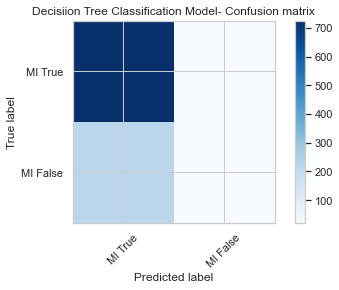

In [1536]:
def plot_confusion_matrix(cm, names, title="Decisiion Tree Classification Model- Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, y_pred_test2)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, ["MI True","MI False"])

Result: we have 725+24 correct predictions and 221+22 incorrect predictions.

In [1537]:
print(classification_report(y_test, y_pred_test2))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       747
           1       0.52      0.10      0.16       245

    accuracy                           0.76       992
   macro avg       0.64      0.53      0.51       992
weighted avg       0.71      0.76      0.69       992



#### After hyperparameter tuning and individual analysis, our decision tree model is doing much better than expected. 
While our accuracy score is at 76%, we can see our model needs more work analyzing positive cases of mental illness against the rest of the data. 

### 9. Random Forest Classifier (Model 3 of 3)
###### Steps
1. Assign RFC
2. Check AUC and cross_val
3. Set parameter grid for hyperparameter tuning
4. Check accuracy and optimal parameters
5. Compare RFC to DTC
6. Confusion matrix
7. Investigate scores

In [1538]:
#Need to investigate class_weight and balance further 
#class_weight = 'balanced' drops all metrics substantially 
#class_weight = 'balanced_subsample' improves metrics slightly
#Need to further exampine sampling
rf_clf = RandomForestClassifier(class_weight = 'balanced_subsample')
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 76.50%


In [1539]:
model3 = RandomForestClassifier()
kfold = KFold(n_splits=3, random_state=42) 
scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
print("Mean AUC Score - Random Forest: ", scores.mean())

Mean AUC Score - Random Forest:  0.6890586874852298


Tune the model. 

In [1540]:
#Setting parameter grid for tuning
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [1541]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 65.81%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 10}


In [1542]:
#Comparing DTC and RFC grid search scores
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

Decision tree grid search:  0.7550403225806451
Random forest grid search:  0.6542338709677419


In [1543]:
#Checking Train/Test Scores
rf_gs_training_score = mean_rf_cv_score

rf_gs_testing_score = rf_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Mean Test Score: {rf_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

Mean Training Score: 76.50%
Mean Test Score: 65.42%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 10}

In [1544]:
pred = rf_grid_search.predict(X_test)
accuracy_score(y_test, pred)

0.6542338709677419

In [1545]:
cmrf = confusion_matrix(y_test, pred)
print(cmrf)

[[504 243]
 [100 145]]


Confusion matrix
[[504 243]
 [100 145]]


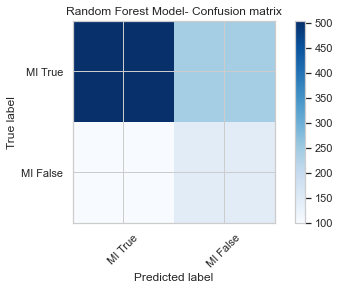

In [1546]:
def plot_confusion_matrix(cm, names, title="Random Forest Model- Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, ["MI True","MI False"])

Result: we have 466+168 correct predictions and 77+281 incorrect predictions.

In [1547]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.67      0.75       747
           1       0.37      0.59      0.46       245

    accuracy                           0.65       992
   macro avg       0.60      0.63      0.60       992
weighted avg       0.72      0.65      0.67       992



#### Our RFC needs some work. 
While its recall score for true cases of mental illness is high, its overall accuracy is low. As suspected, we need to take a closer look at class balance. 

### 10. Conclusion

#### Analysis of Model Performance 
1. Logistic Regression
    - Accuracy: 75%
2. Decision Tree Classifier 
    - Accuracy: 75%
3. Random Forest Classifier 
    - Accuracy: 61%
    
#### Future Steps 
1. Examine feature importance. 
    - While adding in regions and divisions has eased project visualization, further analysis is required to see what sort of weight they carry. 
2. Balance 
    - Prior to passing in "balanced_subsample" for our RFC's class weight, our confusion matrix was completely imbalanced. Passing "balanced" improved matters slightly, but did not help as much as the "balanced_subsample" assignment. 
    - Across the board, our precision and recall scores need to be improved for "true" instances of mental illness. 
3. Model Efficiency 
    - At this moment, our models take quite a bit of time to run. Using a proportioned selection of the data will improve processing time and, depending on the method, may assist with our sampling issue. 
    - This is especially true running a gridsearch for our LogReg model. 
4. ROC/AUC
    - Need to further explore ROC/AUC scores for DTC and RFC

##### Relevant DF and Code Sources
https://github.com/cphalpert/census-regions
https://github.com/washingtonpost/data-police-shootings
http://blog.romanofoti.com/exploratory_classification_analysis/
https://medium.com/analytics-vidhya/automated-eda-for-classification-77c25b847e43